Populating the interactive namespace from numpy and matplotlib
ep= 9.0
1.748983
E_1S =  12.16
E_1G =  7.76
E_1D =  6.71
E_3P =  7.05
E_3F =  4.8


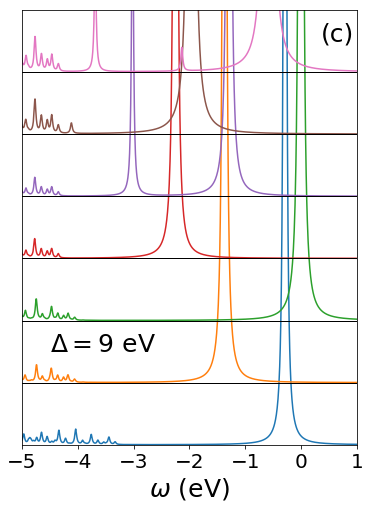

In [7]:
%pylab inline

import math
import numpy as np
from scipy.sparse.linalg import inv
#from numpy.linalg import inv
import scipy.sparse as sps
import scipy.sparse.linalg
import sys
import matplotlib.pyplot as plt
from scipy import interpolate
sys.path.append('../../src/')
from pylab import *

import parameters as pam
import lattice as lat
import variational_space as vs
import hamiltonian as ham
import basis_change as basis
import lanczos

ed = 0
eps = np.arange(9.0, 9.01, 1.0) #[3.5]#,3.5,4.5]
As = np.arange(6.0, 6.01, 0.1)
B = 0.15
C = 0.58
#As = np.arange(100, 100.1, 1.0)
#B = 0
#C = 0

Norb = 7

if Norb<=8:
    tpp = 0.55
    tpd = 1.5
else:
    # for N3 usage only:
    tpp = 0.55
    tpd = 1.5
    
    pds = 1.5
    pdp = 0.75
    #pds = 0.00001
    #pdp = 0.00001
    pps = 0.9
    ppp = 0.2

Upp = 0
Mc = 20
eta = 0.02
symmetries =['1A1','1B1','3B1','1A2','3A2','1E','3E']
symlabels = ['$^{1}A_1$','$^{1}B_1$','$^{3}B_1$','$^{1}A_2$','$^{3}A_2$','$^{1}E$','$^{3}E$']

Ms = ['-b','-r','-g','-m','-c','-k','-y','--b','--r','--g','--m','--c','--k','--y',\
      '-.b','-.r','-.g','-.m','-.c','-.k','-.y',':b',':r',':g',':m',':c',':k',':y']

mode = '_vs_sym' # '_vs_tpd'
offset = 1

if Norb<=8:
    fname = 'ep'+str(eps[0])+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_Upp'+str(Upp)+'_Mc'+str(Mc) \
     +'_Norb'+str(Norb)+'_eta'+str(eta)
else:
    fname = 'ep'+str(eps[0])+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp)+'_Upp'+str(Upp)+'_Mc'+str(Mc) \
     +'_Norb'+str(Norb)+'_eta'+str(eta)
#a = loadtxt('./data_Aw/'+fname+'_cont_bottom.txt',skiprows=0)
#x = [a, a]
#y = [0, 5]

def get_atomic_d8_energy(A,B,C):
    E_1S = A+14*B+7*C
    E_1G = A+4*B+2*C
    E_1D = A-3*B+2*C
    E_3P = A+7*B
    E_3F = A-8*B
    print "E_1S = ", E_1S      
    print "E_1G = ", E_1G     
    print "E_1D = ", E_1D 
    print "E_3P = ", E_3P
    print "E_3F = ", E_3F
    return E_1S, E_1G, E_1D, E_3P, E_3F

def plot_atomic_multiplet_peaks(E_1S, E_1G, E_1D, E_3P, E_3F, E0):
    yy = [0,7]
    xx = [E0-E_1S,E0-E_1S]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1S-0.2, 10.2, 'E_1S', fontsize=5)
    xx = [E0-E_1G,E0-E_1G]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1G-0.2, 10.5, 'E_1G', fontsize=5)
    xx = [E0-E_1D,E0-E_1D]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_1D-0.2, 10.8, 'E_1D', fontsize=5)
    xx = [E0-E_3P,E0-E_3P]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3P-0.2, 11.1, 'E_3P', fontsize=5)
    xx = [E0-E_3F,E0-E_3F]
    plt.plot(xx, yy,'--k', linewidth=0.5)
    #text(pam.E_3F-0.2, 11.4, 'E_3F', fontsize=5)
    
#############################################################################
Nsym = len(symmetries)

plt.figure(figsize=(6,8))

if mode=='_vs_sym':
    for iep in range(0,len(eps)):
        clf()
        ep = eps[iep]
        print 'ep=',str(ep)
        for A in As:
            Udd = A+4*B+3*C
            
            # readin Norb=3 GS energy
            fname = 'Egs_Norb3_tpp'+str(tpp)+'_Upp0_Mc20_eta'+str(eta)
            #a = loadtxt('../twohole_impurity_model/data_GS/'+fname+'.txt',skiprows=0)
            #E0_N3 = a[1,3]
            #print E0_N3
            
            # readin two-hole ground state energy
            if Norb<=8:
                fname = 'Egs_Norb'+str(Norb)+'_tpp'+str(tpp)+'_B'+str(B)+'_C'+str(C)+'_Upp0_Mc'+str(Mc)+'_eta'+str(eta)
            else:
                fname = 'Egs_Norb'+str(Norb)+'_pps'+str(pps)+'_ppp'+str(ppp)+'_B'+str(B)+'_C'+str(C) \
                        +'_Upp0_Mc'+str(Mc)+'_eta'+str(eta)

            a = loadtxt('../twohole_impurity_model/data_GS/'+fname+'.txt',skiprows=0)
            if Norb<=8:
                E0 = a[iep,3]
            else:
                E0 = a[iep,4]
            print E0
            
            for i in range(0,Nsym):
                sym = symmetries[i]

                if Norb<=8:
                    fname = 'ep'+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                              +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta)
                else:
                    fname = 'ep'+str(ep)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp)+'_A'+str(A)+'_B'+str(B) \
                              +'_C'+str(C)+'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta)

                a = loadtxt('./data_Aw/'+fname+'_'+sym+'.txt',skiprows=1)
                #plot(a[:,0], a[:,1]+i*offset, linewidth=1, label='$t_{pd}=$'+str(tpd)+','+sym)
                
                #f = interpolate.interp1d(a[:,0], 10*a[:,1]+i*offset, kind='linear')
                #f = interpolate.Akima1DInterpolator(a[:,0], 10*a[:,1]+i*offset)
                #xx = np.arange(-10.0, 20.0, 0.1/4.)
                #yy = f(xx)
                #plot(xx,yy, linewidth=1, label=symlabels[i])

                plot(a[:,0], 5.*a[:,1]+i*offset, linewidth=1.5, label=symlabels[i])
                
                # try to smooth only part of the curve
                xval = []
                yval = []
                xtemp = []
                ytemp = []
                fp1 = -1.30
                fp2 = 2.50
                for j in range(0,len(a)):
                    if a[j,0]<fp1:
                        xval.append(a[j,0])
                        yval.append(10*a[j,1]+i*offset)
                    elif a[j,0]<fp2:
                        xtemp.append(a[j,0])
                        ytemp.append(10*a[j,1]+i*offset)
                        
                # interpolate the desired interval
                #f = interpolate.interp1d(xtemp, ytemp, kind='quadratic')
                #xx = np.arange(fp1, fp2-0.02, 0.2)
                #yy = f(xx)
                #for j in range(0,len(xx)):
                #    xval.append(xx[j])
                #    yval.append(yy[j])
                #plot(xval, yval, linewidth=1, label=symlabels[i])
                
                if i>0:
                    x1 = [-20, 20]
                    y1 = [i*offset, i*offset]
                    plot(x1, y1, '-k', linewidth=1)

            #plot(x, y, '--r', linewidth=1, label='cont.')
            
            E_1S, E_1G, E_1D, E_3P, E_3F = get_atomic_d8_energy(A,B,C)
            #plot_atomic_multiplet_peaks(E_1S, E_1G, E_1D, E_3P, E_3F, E0)
            
            #if Norb<=8:
            #    title("ep"+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
            #                  +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta),fontsize=8.5)
            #else:
            #    title("ep"+str(ep)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp)+'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
            #                  +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta),fontsize=8.5)
            maxval = max(a[:,1])
            xlim([-5,1])
            #xlim([-18,2])
            #if maxval>20:
            #    ylim([0,20])
            #else:
            #    ylim([0,maxval])
            ylim([0,7*offset])
            xlabel('$\omega$ (eV)',fontsize=25)
            #ylabel('$A_{d^8}(\omega)$',fontsize=19)
            text(0.35, 6.5, '(c)', fontsize=25)
            text(-4.5, 1.5, '$\Delta=9$ eV', fontsize=25)
            #grid('on',linestyle="--", linewidth=0.5, color='black', alpha=0.5)
            #legend(loc=2, fontsize=20, framealpha=1.0, edgecolor='black')
            #xticks([-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2],[-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2])
            xticks(fontsize=20) 
            yticks(fontsize=20) 
            plt.tick_params(axis='y',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            bottom=False,      # ticks along the bottom edge are off
                            top=False,         # ticks along the top edge are off
                            left=False,      # ticks along the bottom edge are off
                            right=False,         # ticks along the top edge are off
                            labelbottom=False) # labels along the bottom edge are off
            plt.yticks([], [])
            
            #axes().set_aspect('equal')
            
            if Norb<=8:
                savefig("Aw"+mode+"_ep"+str(ep)+'_tpd'+str(tpd)+'_tpp'+str(tpp)+'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                              +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta)+".pdf")
            else:
                savefig("Aw"+mode+"_ep"+str(ep)+'_pdp'+str(pdp)+'_pps'+str(pps)+'_ppp'+str(ppp) \
                              +'_A'+str(A)+'_B'+str(B)+'_C'+str(C) \
                              +'_Upp'+str(Upp)+'_Mc'+str(Mc)+'_Norb'+str(Norb)+'_eta'+str(eta)+".pdf")